# Projet Data Mining

Max length = 2753
Max time = 2751 days 23:00:00


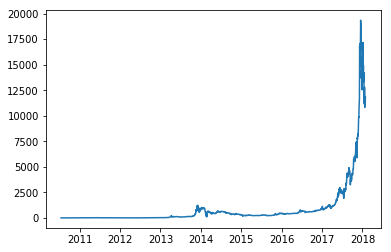

,close,high,low,open,time,volumefrom,volumeto,timestamp
0,0.04951,0.04951,0.04951,0.04951,1279324800,20.00,0.9902,2010-07-17 02:00:00
1,0.08584,0.08585,0.05941,0.04951,1279411200,75.01,5.0900,2010-07-18 02:00:00
2,0.08080,0.09307,0.07723,0.08584,1279497600,574.00,49.6600,2010-07-19 02:00:00
3,0.07474,0.08181,0.07426,0.08080,1279584000,262.00,20.5900,2010-07-20 02:00:00
4,0.07921,0.07921,0.06634,0.07474,1279670400,575.00,42.2600,2010-07-21 02:00:00


In [6]:
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def daily_price_historical(symbol, comparison_symbol, histoday=True, limit=1, aggregate=1, allData='true'):
    # api url
    if histoday:
        url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)
    else:
        url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)

    # fetch data
    page = requests.get(url)
    data = page.json()['Data']

    # Convert Json to Table
    df = pd.DataFrame(data)

    # add a column with timestamp
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]

    return df


df = daily_price_historical('BTC', 'USD', True)
print('Max length = {}'.format(len(df)))
print('Max time = {}'.format((df.timestamp.max() - df.timestamp.min())))

plt.plot(df.timestamp, df.close)
plt.show()
df.head(5)

In [7]:
import numpy as np 
df = np.array(df)
ecart = df[:,0]-df[:,3]

epsilon1 = 0.005
epsilon2 = 2

ecart[(ecart<df[:,3]*epsilon1) & (ecart>-df[:,3]*epsilon1)] = 0
ecart[(ecart>df[:,3]*epsilon1) & (ecart<df[:,3]*epsilon2)] = 1
ecart[ecart>df[:,3]*epsilon2] = 2
ecart[ecart<-df[:,3]*epsilon2] = -2                                 
ecart[(ecart<-df[:,3]*epsilon1) & (ecart>-df[:,3]*epsilon2)] = -1

print(sum(ecart==-2))
print(sum(ecart==-1))
print(sum(ecart==0))
print(sum(ecart==1))
print(sum(ecart==2))

0
964
571
1129
89


### Fonction de création des séquences

In [8]:
def sequences(taille, tab) :
    seq = [tab[i:(i+taille)] for i in range(len(tab[:-(taille-1)]))]
    return seq

### Recherche des séquences qui se répètent de taille max

In [17]:
from collections import Counter
seqtest = sequences(3,ecart)
occmax = 1
tailleseq = 31
while occmax < 2 :
    seqtest = sequences(tailleseq,ecart)
    c = Counter(map(tuple,seqtest))
    c = pd.DataFrame.from_dict(c,orient='index').reset_index()
    c = c.rename(columns = {"index":"sequences",0:"occurences"} )
    c = c.sort_values(by="occurences",ascending=False)
    c = c.reset_index(drop = True)
    c= np.array(c)
    occmax = max(occmax,c[0,1])
    print(occmax)
    tailleseq -= 1
    
print(tailleseq+1)
print(c)
#c[sum(abs(c))>1]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
17
[[(0, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1) 2]
 [(1, -1, 1, 1, 0, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 0, -1) 1]
 [(0, 2, 2, 2, 0, -1, -1, 2, 2, 2, -1, 2, 2, 1, 1, -1, 1) 1]
 ..., 
 [(2, 2, 2, 2, -1, 0, 2, -1, 2, -1, 2, 0, -1, 2, 2, -1, 2) 1]
 [(1, 0, 1, -1, -1, -1, 1, -1, 0, 1, -1, 1, 1, 0, -1, -1, 1) 1]
 [(-1, 1, -1, 1, -1, -1, 0, 0, -1, 1, 1, 0, 0, 1, 1, -1, 1) 1]]


In [144]:
df = pd.read_csv('results.csv', usecols=["Date","Value"])
df['Date'] = [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df.Date]
df = df.set_index('Date')
df

,Value
Date,
2017-02-02,0.0418
2017-02-03,0.0329
2017-02-04,0.0279
2017-02-05,0.0276
2017-02-06,0.0426
2017-02-07,0.0499
2017-02-08,0.0547
2017-02-09,0.0671
2017-02-10,0.0548


30


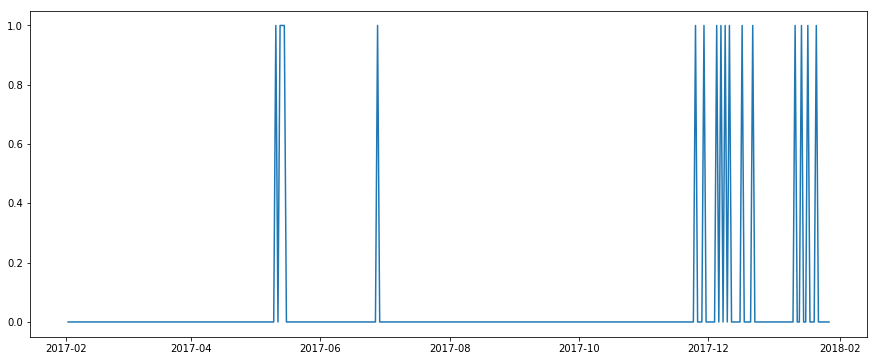

In [145]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


df['mean'] = df.rolling(window=9, center=True).mean()
ts = df['mean']

print(np.count_nonzero(abs(ts-df['Value'])>0.15))

plt.plot(abs(ts-df['Value'])>0.2)


In [154]:
ts-df['Value'])>0.15

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().